# Exercise 1: Structuring a given code

### Original

In [70]:
# file_path = input("Enter the path to the CSV file: ")
# records = []
# with open(file_path, 'r') as file:
#     csv_reader = csv.DictReader(file)
#     for row in csv_reader:
#         records.append(row)

# total = sum(float(record['Grade']) for record in records)
# average = total / len(records)

# print(f"Average Grade: {average}")
# print("--------------------")

# filtered_records = [record for record in records if float(record['Grade']) >= 80.0]

# print("Student Report")
# print("--------------")
# for record in filtered_records:
#     print(f"Name: {record['Name']}")
#     print(f"Grade: {record['Grade']}")
#     print("--------------------")

### Structured

##### Functions

In [71]:
def get_records(path_to_csv: str) -> list[dict[str, str]]:
    """Returns a list of records based on a given path to a CSV.
    
    Arguments:
        path_to_csv (str): The path (relative to the CWD) to a CSV file containting the records.
    Returns:
        list: The records read from the afformentioned file.
    """
    
    records = []
    
    # Read each line of the CSV
    with open(file_path, 'r') as file:
        csv_reader = csv.DictReader(file)
        for row in csv_reader:
            records.append(row)
            
    # Return records
    return records

In [72]:
def get_average_grade(records: list[str]) -> float:
    """Return the average grade for a given list of student records.

    Args:
        records (list): The list of student records.

    Returns:
        float: The average grade.
    """
    
    # Convert grade to float for each records and calculate the average.
    return sum(float(record['Grade']) for record in records) / len(records)

In [73]:
def print_underlined(string: str) -> None:
    """Prints a string followed by dashed on the next line.

    Args:
        string (str): The String to print underlined.
    """
    
    # Determine max line length
    lines = string.split('\n')
    max_line_len = max([len(line) for line in lines])

    # Print with underline
    print(string)
    print("-" * max_line_len)

##### Main

In [74]:
def print_student_reports():
    """Prompts the user to enter a path to a CSV file containing student reports before printing said reports.
    """
    
    
    # Get records based on a user-entered path to a CSV file.
    records = get_records(input("Enter the path to the CSV file: "))

    # Calculate and print the average grade.
    print_underlined(get_average_grade(records))

    # Print student reports where the grade is 8 or higher
    min_grade = 8
    print_underlined("-- Student Reports --")
    for record in records:
        grade = record['Grade']
        if float(grade) >= min_grade:
            print_underlined(f"Name: {record['Name']}\nGrade: {record['Grade']}")

# Exercise 2: Mandelbrot visualisation

### Functions

In [75]:
import cmath                          # Complex number operations.
import matplotlib.pyplot as plt       # Plotting
from matplotlib import colormaps      # Colors
import matplotlib.patches as mpatches # More colors
import numpy as np                    # Array utilities
import random as rng                  # RNG
import time                           # Timing
import threading                      # Multithreading

In [76]:
def enumerate2d(np_array):
    for y, row in enumerate(np_array):
        for x, element in enumerate(row):
            yield (x, y, element)

In [77]:
def get_random_colormap(subtypes: list[str] = None):
    """Returns a random colormap key from matplotlib.colormaps. Optionally filter for colormap types

    Args:
        subtypes (list[str], optional): _description_. Defaults to None. See: https://matplotlib.org/stable/users/explain/colors/colormaps.html

    Returns:
        str: A random colormap key
    """
    
    
    # Source: https://matplotlib.org/stable/users/explain/colors/colormaps.html
    # Diverging and cyclic maps probably won't work well
    cmap_types = {
        'Perceptually Uniform Sequential': [
            'viridis', 'plasma', 'inferno', 'magma', 'cividis'
        ],
        'Sequential' : [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'
        ],
        'Sequential (2)': [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone',
            'pink', 'spring', 'summer', 'autumn', 'winter', 'cool',
            'Wistia', 'hot', 'afmhot', 'gist_heat', 'copper'
        ],
        'Diverging': [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu',
            'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic'
        ],
        'Cyclic': [
            'twilight', 'twilight_shifted', 'hsv'
        ],
        'Qualitative': [
            'Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2',
            'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b',
            'tab20c'
        ],
        'Miscellaneous': [
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain',
            'gist_stern', 'gnuplot', 'gnuplot2', 'CMRmap',
            'cubehelix', 'brg', 'gist_rainbow', 'rainbow', 'jet',
            'turbo', 'nipy_spectral', 'gist_ncar'
        ]
    }
    
    # Return random colormap from selected subtypes (or all if subtypes is None)
    # Syntax is a bit weird. Got it from here:
    # https://stackoverflow.com/questions/952914/how-do-i-make-a-flat-list-out-of-a-list-of-lists
    return rng.choice(
        [
            map for key, cmaps 
            in cmap_types.items() 
            if (
                (subtypes is None) or 
                (key in subtypes)
            )
            for map in cmaps
        ]
    )
    
get_random_colormap()

'Blues'

In [78]:
def get_diverging_index(c: complex, threshhold: float, limit: int) -> int:
    """Returns the mandelbrot diverging-index for c

    Arguments:
        c (complex): A complex number.
        threshhold (float): The threshhold the series must reach to be considered divergent.
        limit (int): The maximum amount of iterations to run.
        
    Returns:
        The diverging-index for c (the iteration at which the threshhold is reached OR the limit if the threshhold is never reached). 
    """

    # Initialize series start and diverging-index.
    a = 0
    i = 0
    
    # Iterate series untill threshhold surpassed OR iteration limit reached.
    while abs(a) <= threshhold and i < limit:
        a = a**2 + c
        i += 1
        
    # Return diverging-index.
    return i

In [79]:
def set_diverging_index(arr, x, y, c, divergence_threshhold, diverging_index_limit):
    # Set diverging index for c
    arr[x, y] = get_diverging_index(c, divergence_threshhold, diverging_index_limit)
    # print(f"Finished ({x},{y})")

In [80]:
def set_diverging_index_rows(thread_index, arr, row_indexes, cs, divergence_threshhold, diverging_index_limit, thread_times):
    
    # DEBUG
    # print(f"Thread #{thread_index}. Processing rows {row_indexes}.")
    
    # Record starting time
    t0 = time.time()
    
    # Loop over rows
    for y in row_indexes:
        
        # Loop over columns
        for x, c in enumerate(cs[:, y]):
            
            # Set diverging index for c
            arr[x, y] = get_diverging_index(c, divergence_threshhold, diverging_index_limit)
            
    # Record execution time
    thread_times[thread_index] = time.time() - t0
        
    # print(f"Finished ({x},{y})")

In [81]:
import multiprocessing

In [82]:
def draw_mandel(
    resolution: tuple[int, int], 
    range_x: tuple[float, float], 
    range_y: tuple[float, float], 
    divergence_threshold: float, 
    diverging_index_limit: int, 
    figsize: tuple[int, int] = (20,10),
    xtick_stepsize: float = 0.2,
    ytick_stepsize: float = 0.2,
    colormap_key: str = 'random',
    processing_mode: str = 'CPU (Singlethread)',
    show_info: bool = False
) -> None:
    """Draws the mandelbrot set

    Args:
        resolution tuple[int, int]: The width and height (respectively) of the image produced.
    """

    
    # Measure starting time
    t0 = time.time()
    
    # Determine points on complex-plane
    cs = np.array(
        [
            [
                complex(x, y) for x in np.linspace(range_x[0], range_x[1], resolution[0])
            ] for y in np.linspace(range_y[0], range_y[1], resolution[1])
        ]
    )
    
    # Create 2D pixel array (scalars) (uint8 is the smallest int type we can use, going up to 255)
    pixels = np.ndarray(cs.shape, np.uint8)
    
    n_cores = 1
    
    match processing_mode:
        case "CPU (Singlethread)":
            for ix in range(cs.shape[0]):
                for iy in range(cs.shape[1]):
                    set_diverging_index(pixels, ix, iy, cs[ix, iy], divergence_threshold, diverging_index_limit)
            
        case "CPU (Multithread)":
            
            # Get the number of logical cpu cores
            n_cores = multiprocessing.cpu_count()
            
            # Divide rows into n_cores peices
            row_indexes_divided = np.split(np.array(range(cs.shape[0])), n_cores)
            
            # DEBUG
            # print(f"Rows divided as such: {row_indexes_divided}")
            
            # Initialize array for keeping track of thread execution times
            thread_times = np.repeat(time.time(), pixels.shape[1])
            
            # Make thread for each row
            threads = [
                threading.Thread(
                    target=set_diverging_index_rows, 
                    args=(
                        thread_index,
                        pixels, 
                        row_indexes, 
                        cs, 
                        divergence_threshold, 
                        diverging_index_limit, 
                        thread_times
                    )
                ) for thread_index, row_indexes in enumerate(row_indexes_divided)
            ]
            
            
            # Iterate over each pixel
            # threads = [threading.Thread(target=set_diverging_index, args=(pixels, ix, iy, pixels_c[ix, iy], divergence_threshhold, diverging_index_limit)) for iy, ix in np.ndindex(pixels.shape)]
            
            
            # # Make thread for each pixel row
            # threads = [threading.Thread(target=set_diverging_index_rows, args=(pixels, ix, cs, divergence_threshold, diverging_index_limit, thread_times)) for ix in range(pixels.shape[1])]
            
            for thread in threads:
                thread.start()
            for thread in threads:
                thread.join()
                
        case _:
            raise ValueError(f"Invalid value for 'mode': {processing_mode}")
    
    
    # Initialize figure
    plt.figure(figsize = figsize)
    
    # Show image with colormap
    cmap = get_random_colormap() if colormap_key == 'random' else colormap_key
    plt.imshow(pixels, origin='lower', cmap = cmap) # Second argument flips y
    
    if show_info:
        
        # Set custom legend for parameters
        cellTexts = [
            ['Resolution:', resolution],
            ['Threshold:', divergence_threshold],
            ['Iterations:', diverging_index_limit],
            ['Colormap:', cmap],
            ['Time [s]:', f"{time.time() - t0:.2f}"]
        ]
        
        # Append info about threads if multithreading
        if processing_mode == 'CPU (Multithread)':
            cellTexts += [
                ['Threads:', n_cores],
                ['Thread-time [s]:', f"{np.array(thread_times).sum():.2f}"]
            ]
            
        # Set cell colors
        cellColours=np.zeros(shape=(len(cellTexts),2,4))
        cellColours[:,:,0:3] = 1  # Color
        cellColours[:,:,3] = 0.75 # Opacity
        
        # Add info table 
        plt.table(
            cellTexts,
            # fontsize = 200, # Doesn't work?
            # cellColours=cellColours, 
            bbox =  [0, 0.85, 0.2, 0.15],
            colWidths=[0.6, 0.4]
        ).set_fontsize(20)
    
    # Set colorbar (on the right)
    cbar = plt.colorbar(ticks=np.linspace(0, diverging_index_limit, 6))
    cbar.ax.set_yticklabels(['0','20','40', '60', '80', '>=100'])
    cbar.set_label('Diverging index', rotation=270)
    
    # Set x ticks
    x_tick_count = (int)((range_x[1] - range_x[0]) // xtick_stepsize + 1)  # floor division (//) returned a float for some reason
    plt.xticks(np.linspace(0, resolution[0], x_tick_count + 1), np.linspace(range_x[0], range_x[1], x_tick_count + 1).round(1))
    
    # Set y ticks
    y_tick_count = (int)((range_y[1] - range_y[0]) // ytick_stepsize + 1)  # floor division (//) returned a float for some reason
    plt.yticks(np.linspace(0, resolution[1], y_tick_count + 1), np.linspace(range_y[0], range_y[1], y_tick_count + 1).round(1))
    
    # Show plot
    plt.show()

### Main

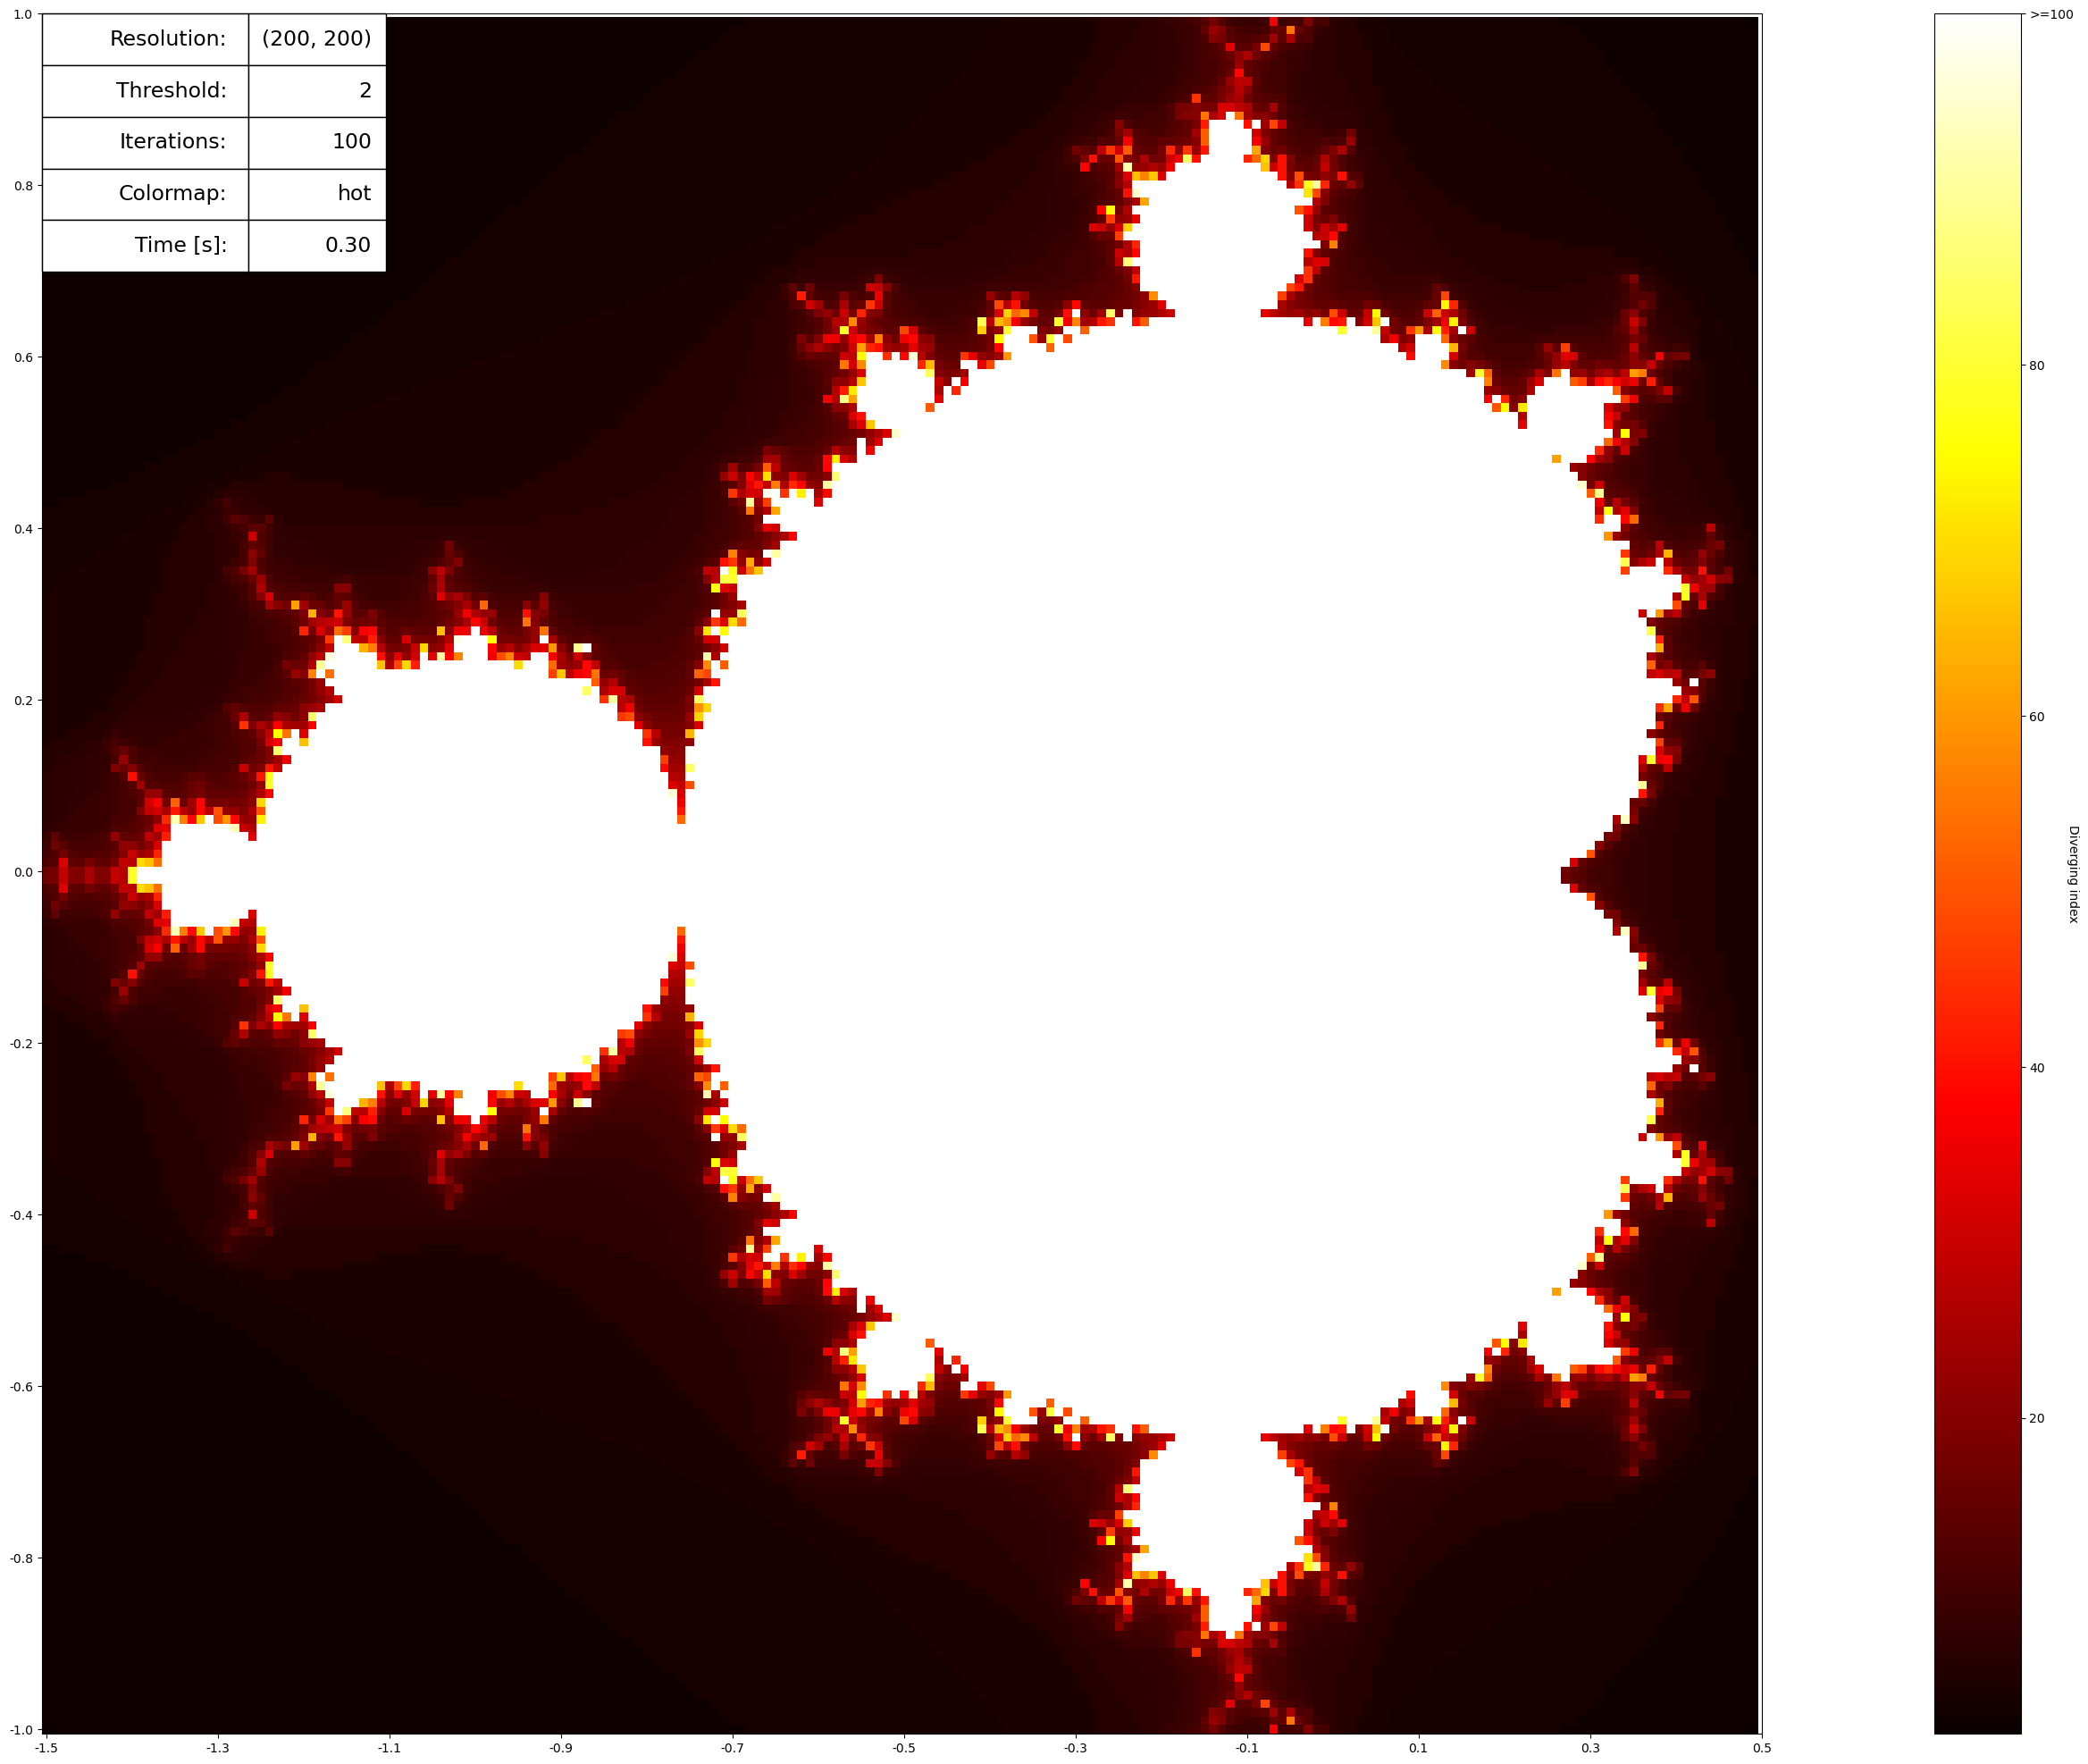

In [83]:
# Settings
resolution =            (200, 200)
range_x =               (-1.5, 0.5)
range_y =               (-1, 1)
divergence_threshold = 2
diverging_index_limit = 100
colormap_key =          'hot'
processing_mode =       'CPU (Singlethread)'  
# processing_mode =       'CPU (Multithread)' # Doesn't work yet
show_info =             True

# Draw mandelbrot
draw_mandel(
    resolution, 
    range_x, 
    range_y, 
    divergence_threshold, 
    diverging_index_limit, 
    figsize=(50,25), 
    colormap_key = colormap_key, 
    processing_mode = processing_mode, 
    show_info = show_info
)

# Exercise 3: Google PageRank algorithm and the worldwide web

In [84]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import pandas as pd

### Functions

In [85]:
def create_star_graph(n0: int) -> nx.Graph:
    """
    Create a star graph with n0 outer nodes connected central node.
    
    Parameters: 
    n0 (int): number outer nodes connected to the central node.
    
    Returns: 
    nx.Graph: manually created star graph.
    """
    graph = nx.Graph()
    graph.add_node(0)  # central node
    
   
    # edges between central  node and outer nodes
    for i in range(1, n0 + 1):
        graph.add_edge(0, i)
        
    return graph

In [86]:
def add_new_node(graph: nx.Graph, m: int) -> None:
    """
    Add a new node and connect it to m existing nodes based on degree probability.
    
    Parameters: 
    graph (nx.Graph): The graph to which a new node will be added.
    m (int): The number of edges the new node will form with existing nodes.
    
    Returns: 
    None
    """
    new_node = len(graph.nodes())  #     new node index is the current number of nodes 
    degrees = dict(graph.degree())  #  degrees of all existing nodes
    total_degree = sum(degrees.values())  # sum of degrees
    
    # Now use the given probability formula
    targets = set()  # store the nodes that the new node will connect to
    
    while len(targets) < m:
        for node in graph.nodes():
            probability = degrees[node] / total_degree  # Probability of connecting to this node
            
            # Randomly decide if the new node connects to this node
            if random.random() < probability and len(targets) < m:
                targets.add(node)
    
    graph.add_node(new_node)  # Add the new node to the graph
    
    # Connect the new node to the selected target nodes
    for target in targets:
        graph.add_edge(new_node, target)

In [87]:
def barabasi_albert_model(n0: int, N: int, M: int) -> nx.Graph:
    """
    Implements the Barabasi-Albert model.
    
    Parameters: 
    n0 (int): number of nodes in the initial star graph.
    N (int): total number of nodes in final graph.
    M (int): number of edges each new node will form.
    
    Returns: 
    nx.Graph: The final graph created using the Barabasi-Albert model.
    """
    graph = create_star_graph(n0)  # Create the initial star graph
    
    # Iteratively add new nodes up to N
    for _ in range(n0, N):
        add_new_node(graph, M)
    
    return graph

In [88]:
def plot_graph(graph: nx.Graph) -> None:
    """
    Visualizes a given networkx graph.
    
    Parameters:
    graph (nx.Graph): The graph to be visualized.
    
    Returns:
    None
    """
    plt.figure(figsize=(20,20))
    nx.draw(graph, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
    plt.show()

In [89]:
def plot_pagerank_distribution(pagerank: dict) -> None:
    """
    Plot the distribution of pagerank values
    
    Parameters:
    pagerank (dict): dictionary of nodes with their PageRank values
    
    Returns: None
    """
    pagerank_values = list(pagerank.values())
    plt.figure(figsize=(8, 6))
    plt.hist(pagerank_values, bins=30)
    plt.title('PageRank Distribution')
    plt.xlabel('PageRank')
    plt.ylabel('Frequency (log)')
    plt.yscale('log')
    plt.grid(True)
    plt.show()

### 3.1: Model a Barabasi-Albert network as described in the introduction.

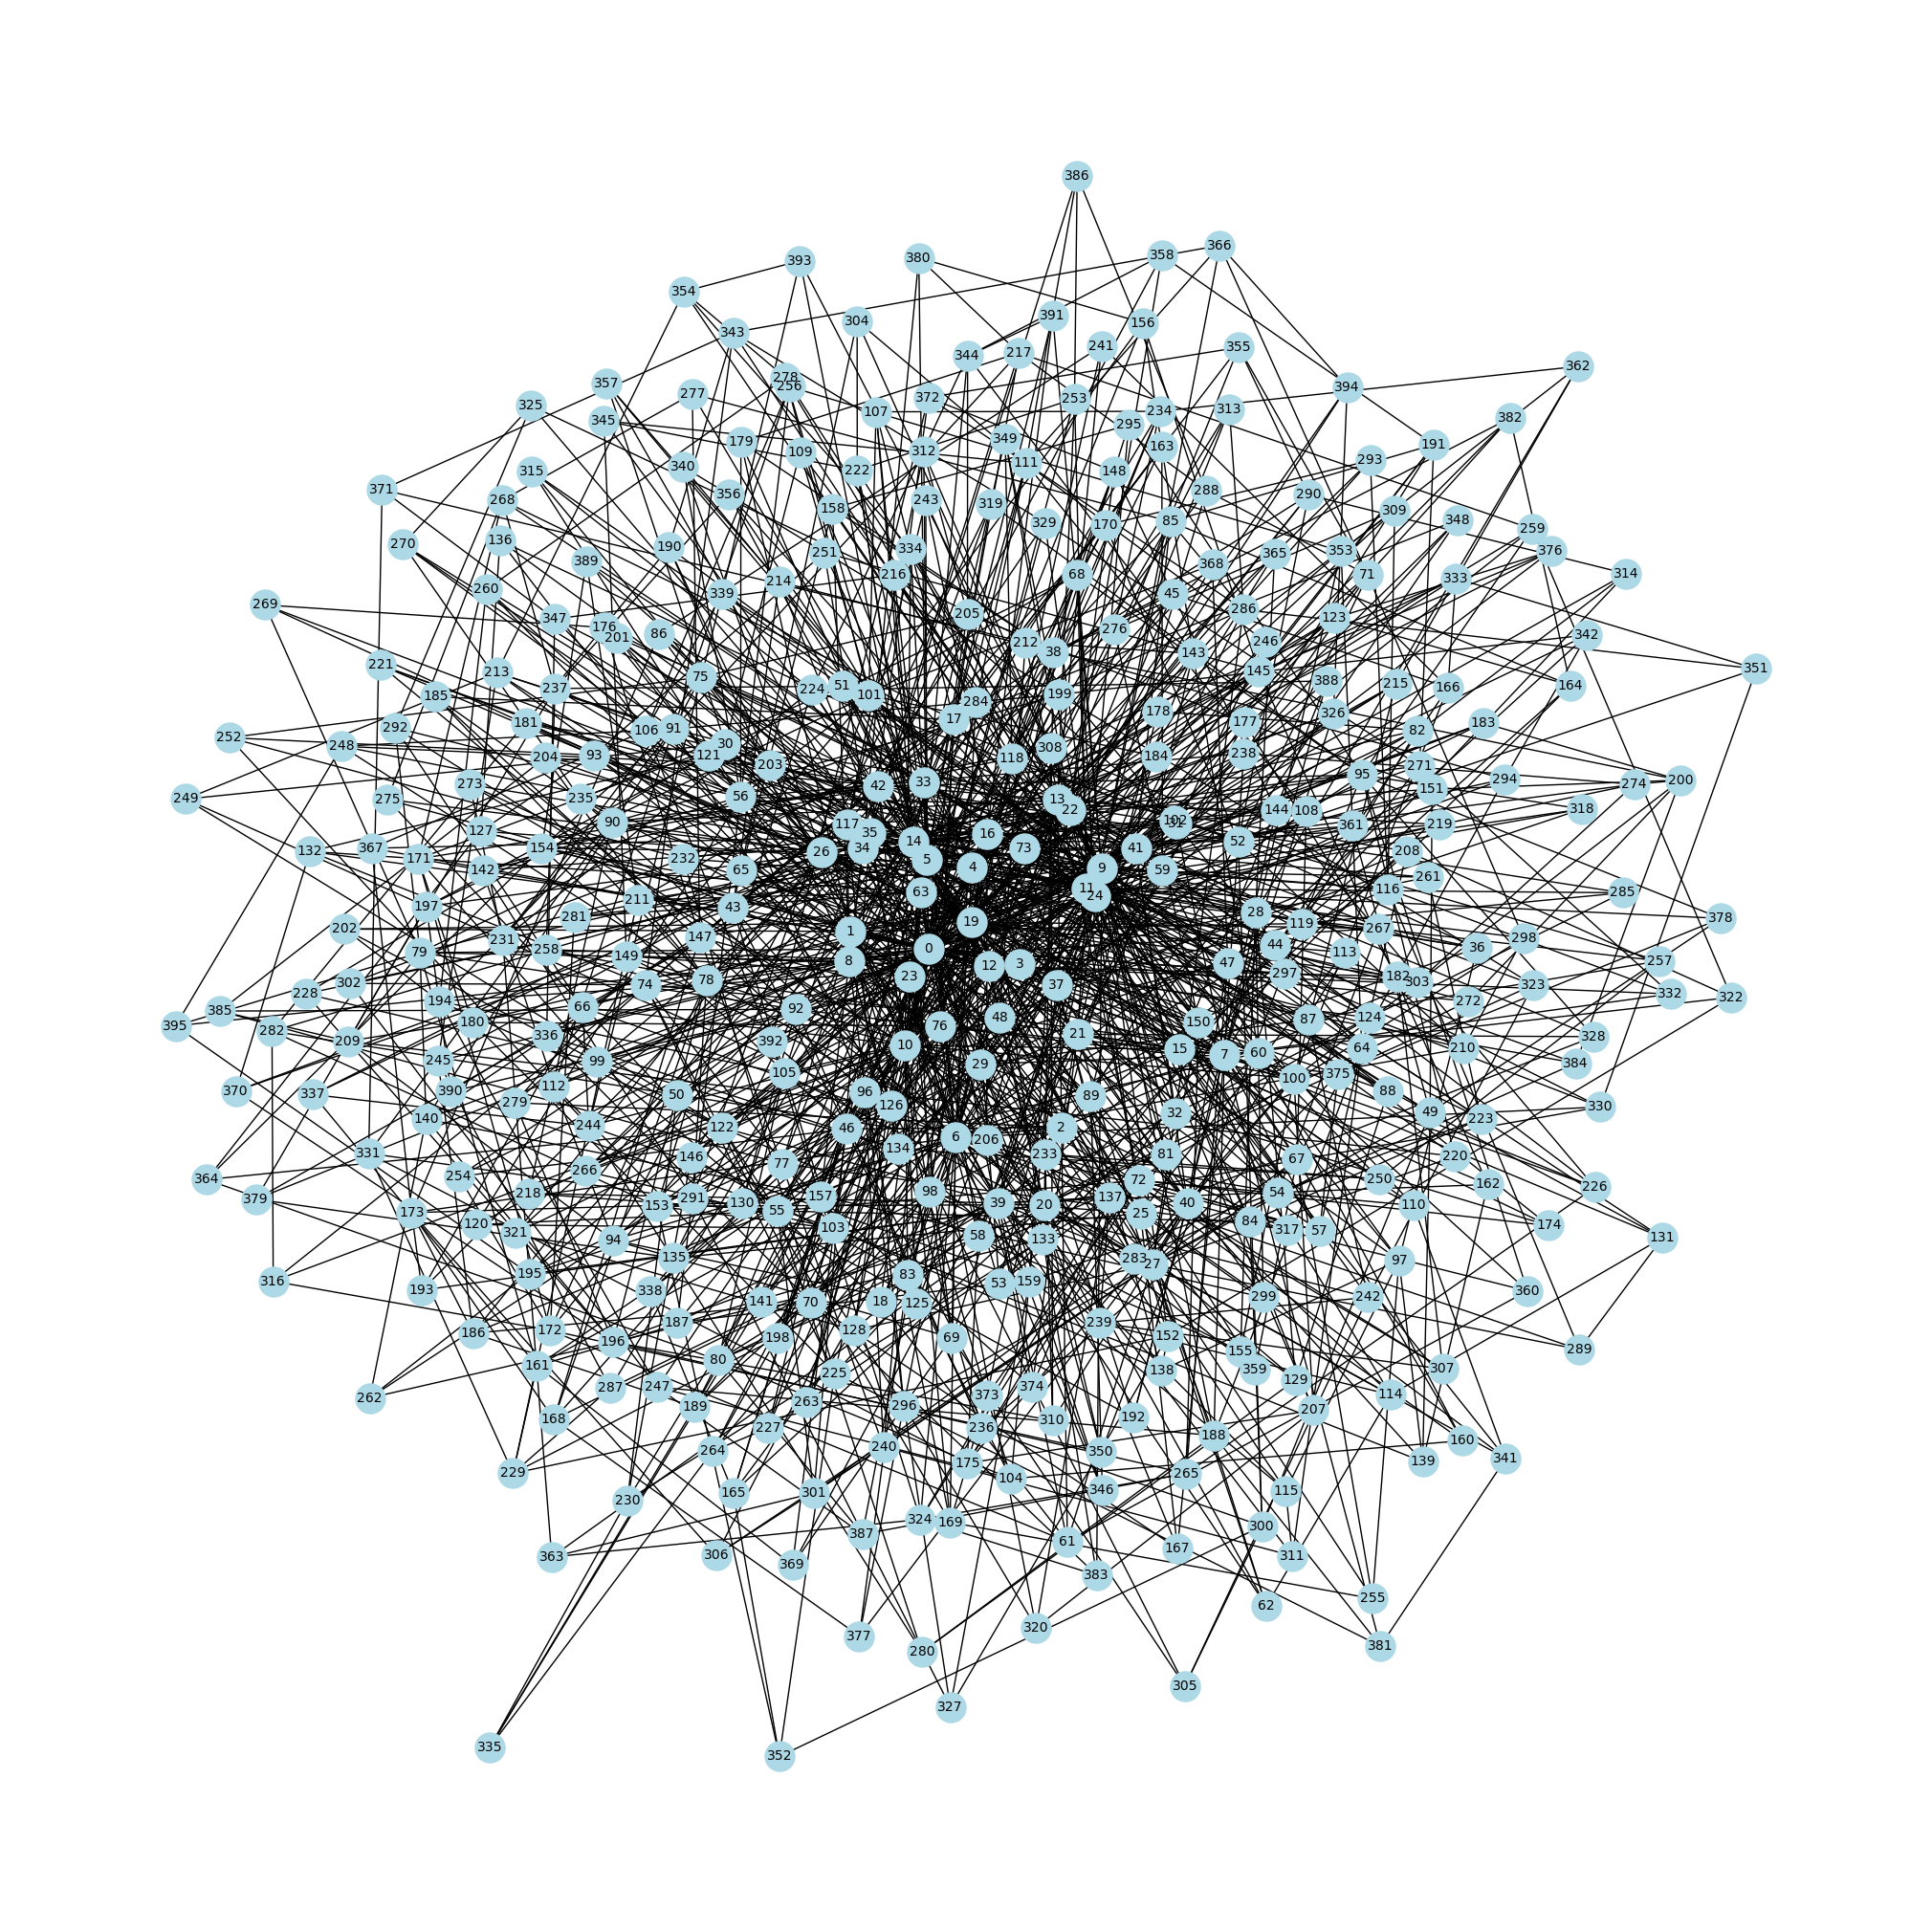

In [90]:
n0 = 5            # Initial number of nodes in the star graph
N_target = 400    # Target number of resulting nodes
N = N_target - n0 # Total number of nodes to be added
M = 4             # Number of edges each new node will create

# Generate the Barabasi-Albert model
graph = barabasi_albert_model(n0, N, M)

# Visualize
plot_graph(graph)

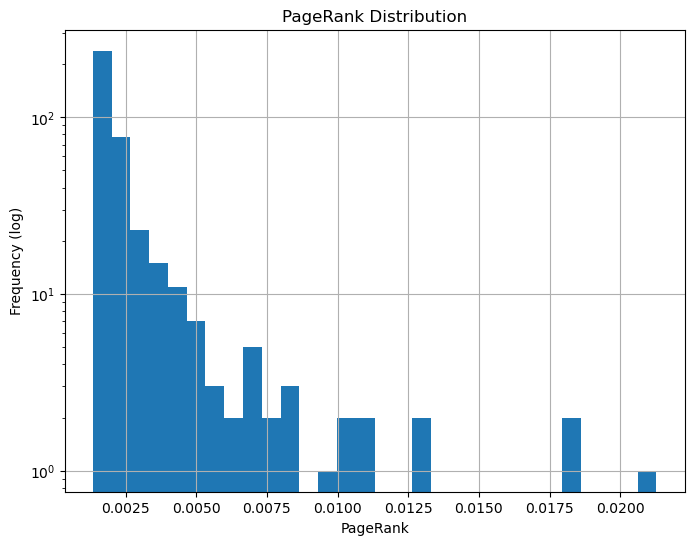

In [91]:
plot_pagerank_distribution(nx.pagerank(graph))

### 3.2: Directed graphs using squirrels

In [92]:
def load_data(file_path: str) -> nx.DiGraph:
    """
    load squirrel data
    
    parameters:
    file_path (str): path to csv file containing source-target edges
    
    returns:
    nx.DiGraph: directed graph
    """
    data = pd.read_csv('squirrel_edges.csv')
    graph = nx.DiGraph() # Create directed graph
    
    # Add edges 
    for index, row in data.iterrows():
        graph.add_edge(row['id1'], row['id2'])
        
    return graph

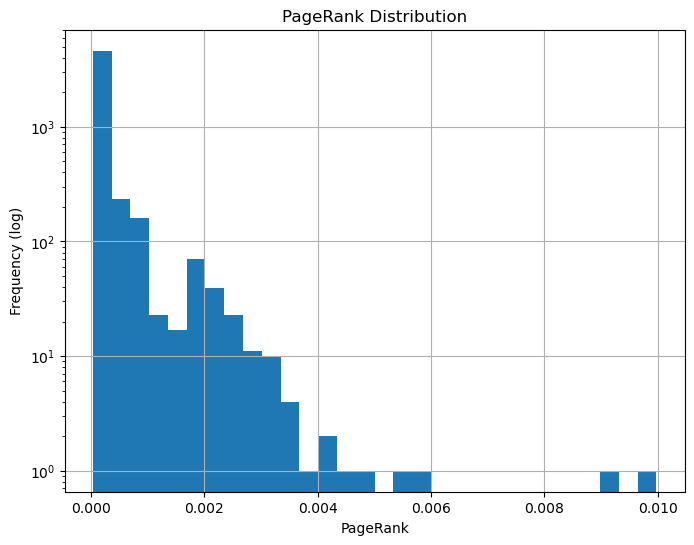

In [93]:
file_path = "squirrel_edges.csv"
squirrel_graph = load_data(file_path)  

# calculate the PageRank for the directed graph directly
pagerank = nx.pagerank(squirrel_graph)

# visualize the distribution of PageRank probabilities
plot_pagerank_distribution(pagerank)